In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import timedelta
from dateutil import parser
import re
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
import os
from sklearn import metrics

In [19]:
df = pd.read_csv('tweets_stocks_combined_for_lstm.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2612 entries, 0 to 2611
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2612 non-null   float64
 1   text                    2562 non-null   object 
 2   favorites               2612 non-null   int64  
 3   retweets                2612 non-null   int64  
 4   date                    2612 non-null   object 
 5   tweet_datetime          2612 non-null   object 
 6   date_part               2612 non-null   object 
 7   time_part               2612 non-null   object 
 8   hour                    2612 non-null   int64  
 9   year                    2612 non-null   int64  
 10  month                   2612 non-null   int64  
 11  datetime_15mins_after   2612 non-null   object 
 12  price_15mins_after      2612 non-null   float64
 13  datetime_now            2612 non-null   object 
 14  price_now               2612 non-null   

In [20]:
model_a_df = df.dropna(subset=['text'])

In [21]:
model_a_df

,id,text,favorites,retweets,date,tweet_datetime,date_part,time_part,hour,year,month,datetime_15mins_after,price_15mins_after,datetime_now,price_now,15mins_price_diff_abs,15mins_price_diff_perc,prev_30mins_prices
0,9.353400e+17,thank you rand,42793,9125,2017-11-28 02:50:00,2017-11-28 10:50:00,2017-11-28,10:50:00,10,2017,11,2017-11-28 11:05:00,261.150000,2017-11-28 10:50:00,261.100000,0.050000,0.000191,"[260.96, 261.03, 261.01, 261.015, 261.04, 261...."
1,8.997980e+17,join me live from fort myer in arlington virginia,36009,4891,2017-08-22 01:00:00,2017-08-22 09:00:00,2017-08-22,09:00:00,9,2017,8,2017-08-22 09:15:00,243.630000,2017-08-22 09:00:00,243.670000,-0.040000,-0.000164,"[243.76, 243.79, 243.85, 243.86, 243.81, 243.7..."
2,8.939700e+17,thank you nicole,43367,8275,2017-05-08 23:01:00,2017-05-09 07:01:00,2017-05-09,07:01:00,7,2017,5,2017-05-09 07:16:00,239.940000,2017-05-09 07:01:00,239.875000,0.065000,0.000271,"[239.73, 239.73, 239.73, 239.73, 239.73, 239.7..."
3,8.819770e+17,thank you to shawn steel for the nice words on,50956,7465,2017-03-07 20:44:00,2017-03-08 04:44:00,2017-03-08,04:44:00,4,2017,3,2017-03-08 04:59:00,236.915000,2017-03-08 04:44:00,236.880000,0.035000,0.000148,"[236.84, 236.84, 236.84, 236.85333333333332, 2..."
4,8.778460e+17,great night in iowa special people thank you,56446,8039,2017-06-22 11:11:00,2017-06-22 19:11:00,2017-06-22,19:11:00,19,2017,6,2017-06-22 19:26:00,242.893333,2017-06-22 19:11:00,242.880000,0.013333,0.000055,"[242.85, 242.85, 242.85, 242.85, 242.85, 242.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2607,9.990960e+17,if the person placed very early into my campai...,78529,20098,2018-05-23 01:13:00,2018-05-23 09:13:00,2018-05-23,09:13:00,9,2018,5,2018-05-23 09:28:00,271.110000,2018-05-23 09:13:00,271.040000,0.070000,0.000258,"[271.18, 271.16, 271.18, 271.15, 271.08, 271.0..."
2608,9.874600e+17,so general michael flynns life can be totally ...,93569,25259,2018-04-20 10:34:00,2018-04-20 18:34:00,2018-04-20,18:34:00,18,2018,4,2018-04-20 18:49:00,266.890000,2018-04-20 18:34:00,266.820000,0.070000,0.000262,"[266.74625000000003, 266.7475, 266.74875, 266...."
2609,9.870960e+17,my thoughts prayers and condolences are with t...,62645,16081,2018-04-19 22:30:00,2018-04-20 06:30:00,2018-04-20,06:30:00,6,2018,4,2018-04-20 06:45:00,268.910000,2018-04-20 06:30:00,268.620000,0.290000,0.001080,"[268.77, 268.74333333333334, 268.7166666666666..."
2610,9.863570e+17,todays court decision means that congress must...,56749,12426,2018-04-17 21:34:00,2018-04-18 05:34:00,2018-04-18,05:34:00,5,2018,4,2018-04-18 05:49:00,270.710000,2018-04-18 05:34:00,270.600000,0.110000,0.000407,"[270.73, 270.7, 270.72749999999996, 270.755, 2..."


# Model A (only word vectors)

In [37]:
model_a_X = model_a_df.loc[:, 'text']
model_a_y = model_a_df.loc[:, '15mins_price_diff_perc']*100

In [38]:
model_a_X_train, model_a_X_test, model_a_y_train, model_a_y_test = train_test_split(model_a_X, model_a_y, test_size=0.33, random_state=42)

In [39]:
model_a_corpus_list = []

for i in model_a_X_train:
    model_a_corpus_list.append(i.split())

In [40]:
model_a_word2vec_model = Word2Vec(model_a_corpus_list, min_count=1, size=100)
model_a_pretrained_weights = model_a_word2vec_model.wv.vectors

In [41]:
model_a_num_words = [len(i) for i in model_a_corpus_list]
model_a_longest_sentence_len = max(model_a_num_words)

In [42]:
def word2vec_sentence_to_indices_padded(sentences, longest_sentence_len, word2vec_model):
    result = []
    for sentence in sentences:
        indices = []
        sentence_splitted = sentence.split()
        for word in sentence_splitted:
            if word in word2vec_model.wv.vocab:
                indices.append(word2vec_model.wv.vocab[word].index)
        result.append(indices)
    return keras.preprocessing.sequence.pad_sequences(result, maxlen=longest_sentence_len, padding='pre')

In [43]:
model_a_X_train_padded = word2vec_sentence_to_indices_padded(model_a_X_train, model_a_longest_sentence_len, model_a_word2vec_model)
model_a_X_test_padded = word2vec_sentence_to_indices_padded(model_a_X_test, model_a_longest_sentence_len, model_a_word2vec_model)

In [30]:
def glove_sentence_to_indices_padded(sentences, longest_sentence_len, glove_model):
    result = []
    for sentence in sentences:
        indices = []
        sentence_splitted = sentence.split()
        for word in sentence_splitted:
            if word in word2vec_model.wv.vocab:
                indices.append(word2vec_model.wv.vocab[word].index)
        result.append(indices)
    return keras.preprocessing.sequence.pad_sequences(result, maxlen=longest_sentence_len, padding='pre')

In [85]:
embeddings_index = {}
f = open('glove/glove.twitter.27B.100d.txt', encoding='utf8')
glove_vocab = []
glove_vocab_index = {}
count = 0
for line in f:
    values = line.split()
    word = values[0]
    glove_vocab.append(word)
    glove_vocab_index[word] = count
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    count += 1
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [59]:
tokenizer = keras.preprocessing.text.Tokenizer(nb_words=None)
tokenizer.fit_on_texts(model_a_X_train)
sequences = tokenizer.texts_to_sequences(model_a_X_train)
word_index = tokenizer.word_index
print(sequences[1])
print('Found %s unique tokens.' % len(word_index))

[1359, 62, 21, 1121, 62, 13, 1, 2550, 25, 1, 1360, 4, 28, 375, 120, 7, 75, 75, 75, 37, 19]
Found 5169 unique tokens.


/Users/Amey/anaconda3/lib/python3.6/site-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [ ]:
glove_word_count = dict(tokenizer.word_counts)
glove_sorted=dict(sorted(glove_word_count.items(), key=lambda x: x[1],reverse=True))
print(glove_sorted)

In [ ]:
w2c = dict()
for item in model_a_word2vec_model.wv.vocab:
    w2c[item]=model_a_word2vec_model.wv.vocab[item].count
w2c_sorted=dict(sorted(w2c.items(), key=lambda x: x[1],reverse=True))
print(w2c_sorted)

In [ ]:
def glove_sentence_to_indices_padded(sentences, longest_sentence_len):
    global glove_vocab
    result = []
    for sentence in sentences:
        indices = []
        sentence_splitted = sentence.split()
        for word in sentence_splitted:
            if word in glove_vocab:
                indices.append(glove_vocab_index[word])
        result.append(indices)
    return keras.preprocessing.sequence.pad_sequences(result, maxlen=longest_sentence_len, padding='post')

In [ ]:
x_train_glove = glove_sentence_to_indices_padded(model_a_X_train, model_a_longest_sentence_len)
x_test_glove = glove_sentence_to_indices_padded(model_a_X_test, model_a_longest_sentence_len)

In [23]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
count = 0
skipped_words = []
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        count += 1
        skipped_words.append(word)
        
vocab_size_glove, embedding_size_glove = embedding_matrix.shape

# print(vocab_size_glove)
# print(embedding_size_glove)
# print(count)
# print(skipped_words)

embedding_layer_glove = Embedding(len(word_index) + 1,
                            100,
                            weights=[embedding_matrix],
                            input_length=model_a_longest_sentence_len,
                            trainable=False)

5170
100
652
['don’t', 'didn’t', '“the', 'it’s', 'doesn’t', 'can’t', 'trump”', 'america’s', 'he’s', 'strzok', 'kavanaugh', 'wasn’t', '“trump', 'that’s', 'couldn’t', '“president', 'americafirst', 'states”', 'aren’t', 'today’s', 'jongun', 'i’m', '“it', 'isn’t', 'shouldn’t', 'i’ve', '“this', 'trump’s', 'rosendale', 'balderson', 'magarally', 'denuclearization', 'we’re', 'jobsnotmobs', 'prstrong', 'wouldn’t', '“you', 'lawabiding', 'they’re', 'we’ve', 'maralago', '“a', 'taxreform', '“collusion”', 'you’re', 'cryin’', 'weren’t', 'councel', 'they’ve', '“i', 'uswomensopen', 'times”', 'happyindependenceday', 'workers”', '“sources”', '“fbi', 'stop”', 'there’s', 'flynn’s', 'he’ll', '“it’s', '“when', 'country’s', 'haven’t', 'hurricanemichael', 'potusabroad', '“these', 'clinton’s', '“they', '“consumer', 'singaporesummit', 'here’s', '“presidential', 'hillary’s', 'sampp', '“o”', 'won’t', 'r’s', 'sheriff’s', '“thank', 'blakeman', 'america”', 'votekarenhandel', '“there', 'obama’s', 'party’s', 'covfefe', 

In [31]:
def create_model_a_2seq_tanh(pretrained_weights, longest_sentence_len):
    global embedding_layer_glove
    vocab_size, embedding_size = pretrained_weights.shape
    model = keras.Sequential()
    model.add(layers.Input(shape=longest_sentence_len, dtype='int32'))
#     model.add(embedding_layer_glove)
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_size, weights=[pretrained_weights], trainable=False))  
    model.add(layers.LSTM(4, return_sequences=True, name='LSTM1'))
    model.add(layers.Dropout(0.25,name='Dropout1'))
    model.add(layers.LSTM(4, return_sequences=False, name='LSTM2'))
    model.add(layers.Dropout(0.25,name='Dropout2'))
    model.add(layers.Dense(4,name='Dense',activation='tanh'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1,activation='linear'))
    return model

In [32]:
def create_model_a_1seq_tanh(pretrained_weights, longest_sentence_len):
    global embedding_layer_glove
    vocab_size, embedding_size = pretrained_weights.shape
    model = keras.Sequential()
    model.add(layers.Input(shape=longest_sentence_len, dtype='int32'))
#     model.add(embedding_layer_glove)
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_size, weights=[pretrained_weights], trainable=False))  
    model.add(layers.LSTM(4, return_sequences=False, name='LSTM2'))
    model.add(layers.Dropout(0.25,name='Dropout2'))
    model.add(layers.Dense(4,name='Dense',activation='tanh'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1,activation='linear'))
    return model

In [33]:
def create_model_a_1seq_sigmoid(pretrained_weights, longest_sentence_len):
    global embedding_layer_glove
    vocab_size, embedding_size = pretrained_weights.shape
    model = keras.Sequential()
    model.add(layers.Input(shape=longest_sentence_len, dtype='int32'))
#     model.add(embedding_layer_glove)
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_size, weights=[pretrained_weights], trainable=False))  
    model.add(layers.LSTM(4, return_sequences=False, name='LSTM2'))
    model.add(layers.Dropout(0.25,name='Dropout2'))
    model.add(layers.Dense(4,name='Dense',activation='sigmoid'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1,activation='linear'))
    return model

In [111]:
def create_model_a_2seq_sigmoid(pretrained_weights, longest_sentence_len):
    global embedding_layer_glove
    vocab_size, embedding_size = pretrained_weights.shape
    model = keras.Sequential()
    model.add(layers.Input(shape=longest_sentence_len, dtype='int32'))
#     model.add(embedding_layer_glove)
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_size, weights=[pretrained_weights], trainable=False))  
    model.add(layers.LSTM(4, return_sequences=True, name='LSTM1'))
    model.add(layers.Dropout(0.25,name='Dropout1'))
    model.add(layers.LSTM(4, return_sequences=False, name='LSTM2'))
    model.add(layers.Dropout(0.25,name='Dropout2'))
    model.add(layers.Dense(4,name='Dense',activation='sigmoid'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1,activation='linear'))
    return model

### 2 LSTMs, tanh activation

In [120]:
model_a_2seq_tanh = create_model_a_2seq_tanh(model_a_pretrained_weights, model_a_longest_sentence_len)
opt = keras.optimizers.Adam(learning_rate=0.001)
model_a_2seq_tanh.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])
model_a_2seq_tanh.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 159, 100)          522200    
_________________________________________________________________
LSTM1 (LSTM)                 (None, 159, 4)            1680      
_________________________________________________________________
Dropout1 (Dropout)           (None, 159, 4)            0         
_________________________________________________________________
LSTM2 (LSTM)                 (None, 4)                 144       
_________________________________________________________________
Dropout2 (Dropout)           (None, 4)                 0         
_________________________________________________________________
Dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dropout_17 (Dropout)         (None, 4)               

In [121]:
from datetime import datetime

now = datetime.now()
dt_string = now.strftime("%d%m%Y %H%Mh")

checkpoint_filepath = f'./model_a_checkpoint/model_a_2seq_tanh {dt_string}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose = 1,
    save_best_only=True) 

model_a_2seq_tanh_history = model_a_2seq_tanh.fit(model_a_X_train_padded, model_a_y_train, validation_split=0.2, epochs=50, callbacks=[model_checkpoint_callback])

Train on 1372 samples, validate on 344 samples
Epoch 1/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.0072 - mae: 0.0482
Epoch 00001: val_loss improved from inf to 0.00469, saving model to ./model_a_checkpoint/model_a_2seq_tanh 11112020 1852h.h5
1372/1372 [==============================] - 8s 6ms/sample - loss: 0.0071 - mae: 0.0477 - val_loss: 0.0047 - val_mae: 0.0378
Epoch 2/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0391
Epoch 00002: val_loss improved from 0.00469 to 0.00457, saving model to ./model_a_checkpoint/model_a_2seq_tanh 11112020 1852h.h5
1372/1372 [==============================] - 4s 3ms/sample - loss: 0.0064 - mae: 0.0389 - val_loss: 0.0046 - val_mae: 0.0348
Epoch 3/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.0063 - mae: 0.0382
Epoch 00003: val_loss did not improve from 0.00457
1372/1372 [==============================] - 4s 3ms/sample - loss: 0.0064 - mae: 0.0386 - val_loss: 0.0046 - val_mae: 0

Epoch 30/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0379
Epoch 00030: val_loss did not improve from 0.00455
1372/1372 [==============================] - 4s 3ms/sample - loss: 0.0064 - mae: 0.0377 - val_loss: 0.0046 - val_mae: 0.0350
Epoch 31/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0376
Epoch 00031: val_loss did not improve from 0.00455
1372/1372 [==============================] - 4s 3ms/sample - loss: 0.0064 - mae: 0.0371 - val_loss: 0.0046 - val_mae: 0.0342
Epoch 32/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0375
Epoch 00032: val_loss did not improve from 0.00455
1372/1372 [==============================] - 4s 3ms/sample - loss: 0.0064 - mae: 0.0373 - val_loss: 0.0046 - val_mae: 0.0348
Epoch 33/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.0054 - mae: 0.0360
Epoch 00033: val_loss did not improve from 0.00455
1372/1372 [==============================] - 

In [122]:
model_a_2seq_tanh_loaded = create_model_a_2seq_tanh(model_a_pretrained_weights, model_a_longest_sentence_len)
model_a_2seq_tanh_loaded.load_weights(checkpoint_filepath)
model_a_2seq_tanh_loaded.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])
model_a_2seq_tanh_pred = model_a_2seq_tanh_loaded.predict(model_a_X_test_padded)
model_a_2seq_tanh_pred

array([[0.00152868],
       [0.00139915],
       [0.00167112],
       [0.00160962],
       [0.00176441],
       [0.00155087],
       [0.00176477],
       [0.00158254],
       [0.00166291],
       [0.00117626],
       [0.0019331 ],
       [0.00129923],
       [0.00152098],
       [0.0023543 ],
       [0.00176979],
       [0.00166193],
       [0.00170861],
       [0.00178246],
       [0.00175226],
       [0.0018637 ],
       [0.00168709],
       [0.00159256],
       [0.00176223],
       [0.00174286],
       [0.00179702],
       [0.0016817 ],
       [0.00163848],
       [0.0013097 ],
       [0.00196105],
       [0.00175423],
       [0.00161763],
       [0.00173057],
       [0.00166576],
       [0.00188478],
       [0.00144834],
       [0.001554  ],
       [0.00167813],
       [0.00149864],
       [0.00187939],
       [0.00094656],
       [0.00123483],
       [0.00162814],
       [0.00164099],
       [0.00197306],
       [0.00042266],
       [0.00154643],
       [0.00118938],
       [0.001

In [123]:
dev_loss, dev_acc = model_a_2seq_tanh_loaded.evaluate(model_a_X_test_padded,  model_a_y_test, verbose=1)

print(f"Training MSE: {np.sqrt( metrics.mean_squared_error(model_a_y_train, model_a_2seq_tanh_loaded.predict(model_a_X_train_padded)))}")
print(f"Test MSE: {np.sqrt( metrics.mean_squared_error(model_a_y_test, model_a_2seq_tanh_loaded.predict(model_a_X_test_padded)) ) }")
print(f"Baseline MSE: {np.sqrt( metrics.mean_squared_error(model_a_y_test, 0*model_a_y_test ) ) }")

846/846 [==============================] - 1s 2ms/sample - loss: 0.0071 - mae: 0.0353
Training MSE: 0.07733019570591906
Test MSE: 0.08407118843118702
Baseline MSE: 0.08418924631944838


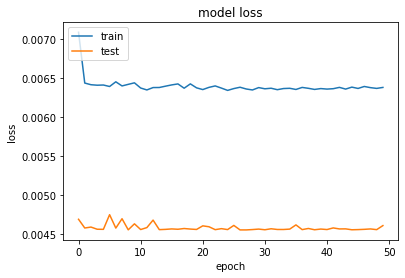

In [124]:
# summarize history for loss
plt.plot(model_a_2seq_tanh_history.history['loss'])
plt.plot(model_a_2seq_tanh_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 1 LSTM, tanh activation

In [125]:
model_a_1seq_tanh = create_model_a_1seq_tanh(model_a_pretrained_weights, model_a_longest_sentence_len)
opt = keras.optimizers.Adam(learning_rate=0.001)
model_a_1seq_tanh.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])
model_a_1seq_tanh.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 159, 100)          522200    
_________________________________________________________________
LSTM2 (LSTM)                 (None, 4)                 1680      
_________________________________________________________________
Dropout2 (Dropout)           (None, 4)                 0         
_________________________________________________________________
Dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dropout_19 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 5         
Total params: 523,905
Trainable params: 1,705
Non-trainable params: 522,200
___________________________________________

In [126]:
from datetime import datetime

now = datetime.now()
dt_string = now.strftime("%d%m%Y %H%Mh")

checkpoint_filepath = f'./model_a_checkpoint/model_a_1seq_tanh {dt_string}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose = 1,
    save_best_only=True) 

model_a_1seq_tanh_history = model_a_1seq_tanh.fit(model_a_X_train_padded, model_a_y_train, validation_split=0.2, epochs=50, callbacks=[model_checkpoint_callback])

Train on 1372 samples, validate on 344 samples
Epoch 1/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.0271 - mae: 0.1046
Epoch 00001: val_loss improved from inf to 0.00483, saving model to ./model_a_checkpoint/model_a_1seq_tanh 11112020 1856h.h5
1372/1372 [==============================] - 4s 3ms/sample - loss: 0.0266 - mae: 0.1033 - val_loss: 0.0048 - val_mae: 0.0418
Epoch 2/50
1312/1372 [===========================>..] - ETA: 0s - loss: 0.0069 - mae: 0.0438
Epoch 00002: val_loss improved from 0.00483 to 0.00471, saving model to ./model_a_checkpoint/model_a_1seq_tanh 11112020 1856h.h5
1372/1372 [==============================] - 2s 2ms/sample - loss: 0.0067 - mae: 0.0431 - val_loss: 0.0047 - val_mae: 0.0387
Epoch 3/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0392
Epoch 00003: val_loss improved from 0.00471 to 0.00454, saving model to ./model_a_checkpoint/model_a_1seq_tanh 11112020 1856h.h5
1372/1372 [==============================

1344/1372 [============================>.] - ETA: 0s - loss: 0.0063 - mae: 0.0383
Epoch 00030: val_loss did not improve from 0.00454
1372/1372 [==============================] - 2s 2ms/sample - loss: 0.0064 - mae: 0.0386 - val_loss: 0.0046 - val_mae: 0.0348
Epoch 31/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0383
Epoch 00031: val_loss did not improve from 0.00454
1372/1372 [==============================] - 2s 2ms/sample - loss: 0.0064 - mae: 0.0380 - val_loss: 0.0046 - val_mae: 0.0361
Epoch 32/50
1312/1372 [===========================>..] - ETA: 0s - loss: 0.0063 - mae: 0.0388
Epoch 00032: val_loss did not improve from 0.00454
1372/1372 [==============================] - 2s 2ms/sample - loss: 0.0064 - mae: 0.0388 - val_loss: 0.0046 - val_mae: 0.0356
Epoch 33/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0385
Epoch 00033: val_loss did not improve from 0.00454
1372/1372 [==============================] - 2s 2ms/sampl

In [127]:
model_a_1seq_tanh_loaded = create_model_a_1seq_tanh(model_a_pretrained_weights, model_a_longest_sentence_len)
model_a_1seq_tanh_loaded.load_weights(checkpoint_filepath)
model_a_1seq_tanh_loaded.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])
model_a_1seq_tanh_pred = model_a_1seq_tanh_loaded.predict(model_a_X_test_padded)
model_a_1seq_tanh_pred

array([[ 1.83341862e-03],
       [ 1.43237016e-03],
       [ 7.73080625e-04],
       [ 4.02416708e-03],
       [ 7.06388941e-03],
       [ 3.32023180e-03],
       [ 4.78567975e-03],
       [ 1.65059092e-03],
       [ 2.63031223e-03],
       [ 1.76591892e-03],
       [ 3.33504146e-03],
       [ 8.55704304e-04],
       [ 2.90811295e-03],
       [ 6.03189506e-03],
       [ 2.30995892e-03],
       [ 4.64002322e-03],
       [ 1.29768113e-03],
       [ 1.14364596e-03],
       [ 5.14863385e-03],
       [ 2.58132280e-03],
       [-1.62007893e-03],
       [ 9.73038375e-04],
       [ 2.35096272e-03],
       [ 4.52719210e-03],
       [ 2.01788032e-03],
       [ 5.28745120e-03],
       [ 1.45520642e-03],
       [-2.44638155e-04],
       [ 3.13458173e-03],
       [ 3.35191749e-03],
       [ 3.95391631e-04],
       [ 2.22323975e-03],
       [ 3.06605408e-03],
       [ 3.58972349e-03],
       [ 5.67039615e-03],
       [ 2.82368599e-03],
       [ 2.84025911e-03],
       [ 1.89252663e-03],
       [ 1.8

In [128]:
dev_loss, dev_acc = model_a_1seq_tanh_loaded.evaluate(model_a_X_test_padded,  model_a_y_test, verbose=1)

print(f"Training MSE: {np.sqrt( metrics.mean_squared_error(model_a_y_train, model_a_1seq_tanh_loaded.predict(model_a_X_train_padded)))}")
print(f"Test MSE: {np.sqrt( metrics.mean_squared_error(model_a_y_test, model_a_1seq_tanh_loaded.predict(model_a_X_test_padded)) ) }")
print(f"Baseline MSE: {np.sqrt( metrics.mean_squared_error(model_a_y_test, 0*model_a_y_test ) ) }")

846/846 [==============================] - 1s 949us/sample - loss: 0.0071 - mae: 0.0356
Training MSE: 0.07729923417970892
Test MSE: 0.08399772207905713
Baseline MSE: 0.08418924631944838


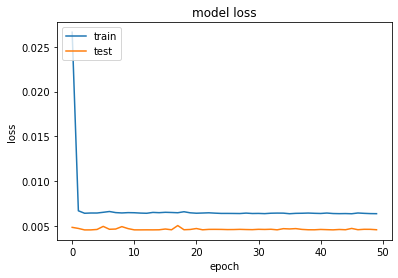

In [129]:
# summarize history for loss
plt.plot(model_a_1seq_tanh_history.history['loss'])
plt.plot(model_a_1seq_tanh_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 2 LSTMs, sigmoid activation

In [130]:
model_a_2seq_sigmoid = create_model_a_2seq_sigmoid(model_a_pretrained_weights, model_a_longest_sentence_len)
opt = keras.optimizers.Adam(learning_rate=0.001)
model_a_2seq_sigmoid.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])
model_a_2seq_sigmoid.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 159, 100)          522200    
_________________________________________________________________
LSTM1 (LSTM)                 (None, 159, 4)            1680      
_________________________________________________________________
Dropout1 (Dropout)           (None, 159, 4)            0         
_________________________________________________________________
LSTM2 (LSTM)                 (None, 4)                 144       
_________________________________________________________________
Dropout2 (Dropout)           (None, 4)                 0         
_________________________________________________________________
Dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dropout_21 (Dropout)         (None, 4)               

In [131]:
from datetime import datetime

now = datetime.now()
dt_string = now.strftime("%d%m%Y %H%Mh")

checkpoint_filepath = f'./model_a_checkpoint/model_a_2seq_sigmoid {dt_string}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose = 1,
    save_best_only=True) 

model_a_2seq_sigmoid_history = model_a_2seq_sigmoid.fit(model_a_X_train_padded, model_a_y_train, validation_split=0.2, epochs=50, callbacks=[model_checkpoint_callback])

Train on 1372 samples, validate on 344 samples
Epoch 1/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.0602 - mae: 0.1957
Epoch 00001: val_loss improved from inf to 0.00690, saving model to ./model_a_checkpoint/model_a_2seq_sigmoid 11112020 1858h.h5
1372/1372 [==============================] - 9s 7ms/sample - loss: 0.0595 - mae: 0.1942 - val_loss: 0.0069 - val_mae: 0.0612
Epoch 2/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.0271 - mae: 0.1116
Epoch 00002: val_loss improved from 0.00690 to 0.00452, saving model to ./model_a_checkpoint/model_a_2seq_sigmoid 11112020 1858h.h5
1372/1372 [==============================] - 4s 3ms/sample - loss: 0.0275 - mae: 0.1123 - val_loss: 0.0045 - val_mae: 0.0346
Epoch 3/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.0212 - mae: 0.1001
Epoch 00003: val_loss improved from 0.00452 to 0.00451, saving model to ./model_a_checkpoint/model_a_2seq_sigmoid 11112020 1858h.h5
1372/1372 [=====================

1344/1372 [============================>.] - ETA: 0s - loss: 0.0073 - mae: 0.0456
Epoch 00030: val_loss did not improve from 0.00451
1372/1372 [==============================] - 4s 3ms/sample - loss: 0.0072 - mae: 0.0453 - val_loss: 0.0045 - val_mae: 0.0347
Epoch 31/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.0072 - mae: 0.0468- ETA: 1s - loss: 0.0072 - 
Epoch 00031: val_loss did not improve from 0.00451
1372/1372 [==============================] - 4s 3ms/sample - loss: 0.0072 - mae: 0.0467 - val_loss: 0.0046 - val_mae: 0.0349
Epoch 32/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.0073 - mae: 0.0458
Epoch 00032: val_loss did not improve from 0.00451
1372/1372 [==============================] - 4s 3ms/sample - loss: 0.0072 - mae: 0.0454 - val_loss: 0.0045 - val_mae: 0.0343
Epoch 33/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.0074 - mae: 0.0446
Epoch 00033: val_loss did not improve from 0.00451
1372/1372 [===================

In [132]:
model_a_2seq_sigmoid_loaded = create_model_a_2seq_sigmoid(model_a_pretrained_weights, model_a_longest_sentence_len)
model_a_2seq_sigmoid_loaded.load_weights(checkpoint_filepath)
model_a_2seq_sigmoid_loaded.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])
model_a_2seq_sigmoid_pred = model_a_2seq_sigmoid_loaded.predict(model_a_X_test_padded)
model_a_2seq_sigmoid_pred

array([[-6.45041466e-04],
       [ 5.68476319e-03],
       [ 2.97543406e-03],
       [ 1.93116069e-03],
       [ 1.40313804e-03],
       [-1.86766684e-03],
       [-2.02372670e-03],
       [ 1.68830156e-03],
       [-1.08802319e-03],
       [ 1.40219927e-03],
       [-1.41905248e-03],
       [ 2.08939612e-03],
       [ 4.49046493e-04],
       [-4.36976552e-04],
       [ 7.44998455e-04],
       [ 1.91606581e-03],
       [-6.47604465e-04],
       [-4.46408987e-04],
       [ 1.66416168e-04],
       [ 4.64215875e-04],
       [-1.27208233e-03],
       [-7.66068697e-04],
       [-3.62783670e-04],
       [-2.22682953e-03],
       [ 2.61202455e-04],
       [ 1.76736712e-03],
       [ 8.01786780e-04],
       [ 2.58947909e-03],
       [-3.08156013e-04],
       [-1.50503218e-03],
       [-1.09787285e-03],
       [-6.94438815e-04],
       [ 2.46748328e-03],
       [-1.40944123e-03],
       [ 2.44632363e-03],
       [-1.76410377e-03],
       [-1.98146701e-03],
       [ 6.64131343e-03],
       [-8.2

In [133]:
dev_loss, dev_acc = model_a_2seq_sigmoid_loaded.evaluate(model_a_X_test_padded,  model_a_y_test, verbose=1)

print(f"Training MSE: {np.sqrt( metrics.mean_squared_error(model_a_y_train, model_a_2seq_sigmoid_loaded.predict(model_a_X_train_padded)))}")
print(f"Test MSE: {np.sqrt( metrics.mean_squared_error(model_a_y_test, model_a_2seq_sigmoid_loaded.predict(model_a_X_test_padded)) ) }")
print(f"Baseline MSE: {np.sqrt( metrics.mean_squared_error(model_a_y_test, 0*model_a_y_test ) ) }")

846/846 [==============================] - 1s 2ms/sample - loss: 0.0071 - mae: 0.0357
Training MSE: 0.07739601327729813
Test MSE: 0.08426806740665316
Baseline MSE: 0.08418924631944838


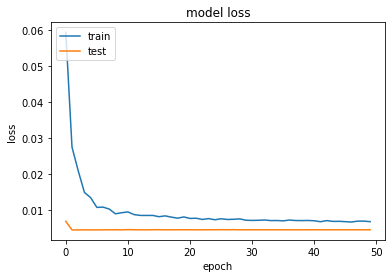

In [134]:
# summarize history for loss
plt.plot(model_a_2seq_sigmoid_history.history['loss'])
plt.plot(model_a_2seq_sigmoid_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 1 LSTM, sigmoid activation

In [135]:
model_a_1seq_sigmoid = create_model_a_1seq_sigmoid(model_a_pretrained_weights, model_a_longest_sentence_len)
opt = keras.optimizers.Adam(learning_rate=0.001)
model_a_1seq_sigmoid.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])
model_a_1seq_sigmoid.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 159, 100)          522200    
_________________________________________________________________
LSTM2 (LSTM)                 (None, 4)                 1680      
_________________________________________________________________
Dropout2 (Dropout)           (None, 4)                 0         
_________________________________________________________________
Dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dropout_23 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 5         
Total params: 523,905
Trainable params: 1,705
Non-trainable params: 522,200
___________________________________________

In [136]:
from datetime import datetime

now = datetime.now()
dt_string = now.strftime("%d%m%Y %H%Mh")

checkpoint_filepath = f'./model_a_checkpoint/model_a_1seq_sigmoid {dt_string}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose = 1,
    save_best_only=True) 

model_a_1seq_sigmoid_history = model_a_1seq_sigmoid.fit(model_a_X_train_padded, model_a_y_train, validation_split=0.2, epochs=50, callbacks=[model_checkpoint_callback])

Train on 1372 samples, validate on 344 samples
Epoch 1/50
1344/1372 [============================>.] - ETA: 0s - loss: 1.6349 - mae: 1.2503
Epoch 00001: val_loss improved from inf to 1.16077, saving model to ./model_a_checkpoint/model_a_1seq_sigmoid 11112020 1901h.h5
1372/1372 [==============================] - 4s 3ms/sample - loss: 1.6261 - mae: 1.2465 - val_loss: 1.1608 - val_mae: 1.0748
Epoch 2/50
1344/1372 [============================>.] - ETA: 0s - loss: 1.0058 - mae: 0.9727
Epoch 00002: val_loss improved from 1.16077 to 0.69606, saving model to ./model_a_checkpoint/model_a_1seq_sigmoid 11112020 1901h.h5
1372/1372 [==============================] - 2s 2ms/sample - loss: 1.0002 - mae: 0.9694 - val_loss: 0.6961 - val_mae: 0.8298
Epoch 3/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.6437 - mae: 0.7705
Epoch 00003: val_loss improved from 0.69606 to 0.43216, saving model to ./model_a_checkpoint/model_a_1seq_sigmoid 11112020 1901h.h5
1372/1372 [=====================

Epoch 00026: val_loss did not improve from 0.00539
1372/1372 [==============================] - 2s 2ms/sample - loss: 0.0264 - mae: 0.1236 - val_loss: 0.0077 - val_mae: 0.0638
Epoch 27/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.0248 - mae: 0.1215
Epoch 00027: val_loss did not improve from 0.00539
1372/1372 [==============================] - 2s 2ms/sample - loss: 0.0249 - mae: 0.1217 - val_loss: 0.0078 - val_mae: 0.0647
Epoch 28/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.0250 - mae: 0.1220
Epoch 00028: val_loss did not improve from 0.00539
1372/1372 [==============================] - 2s 2ms/sample - loss: 0.0251 - mae: 0.1222 - val_loss: 0.0077 - val_mae: 0.0641
Epoch 29/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.0236 - mae: 0.1203
Epoch 00029: val_loss did not improve from 0.00539
1372/1372 [==============================] - 2s 2ms/sample - loss: 0.0236 - mae: 0.1204 - val_loss: 0.0076 - val_mae: 0.0636
Epoch 30/50
13

In [137]:
model_a_1seq_sigmoid_loaded = create_model_a_1seq_sigmoid(model_a_pretrained_weights, model_a_longest_sentence_len)
model_a_1seq_sigmoid_loaded.load_weights(checkpoint_filepath)
model_a_1seq_sigmoid_loaded.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])
model_a_1seq_sigmoid_pred = model_a_1seq_sigmoid_loaded.predict(model_a_X_test_padded)
model_a_1seq_sigmoid_pred

array([[ 2.78998613e-02],
       [-4.34081852e-02],
       [-3.82755101e-02],
       [-1.06232166e-02],
       [ 3.12184691e-02],
       [ 2.79015005e-02],
       [-1.22154653e-02],
       [ 2.03187764e-02],
       [ 2.89802551e-02],
       [-1.92942917e-02],
       [-3.30637991e-02],
       [-1.33588016e-02],
       [ 2.78736651e-02],
       [ 3.12002301e-02],
       [ 1.15357935e-02],
       [ 3.11525166e-02],
       [-3.06035876e-02],
       [ 1.41701698e-02],
       [ 1.67392790e-02],
       [-2.47534215e-02],
       [ 5.63243032e-03],
       [-4.16976213e-03],
       [ 1.07738376e-03],
       [ 1.67509913e-02],
       [ 2.67775357e-02],
       [ 3.07455957e-02],
       [ 2.43682563e-02],
       [-3.51713002e-02],
       [ 1.84684992e-04],
       [ 8.77097249e-03],
       [ 1.84537470e-02],
       [-1.84258819e-03],
       [-2.52652466e-02],
       [ 1.89618468e-02],
       [ 1.25130117e-02],
       [ 2.79015005e-02],
       [ 2.79015005e-02],
       [-1.39169395e-02],
       [-5.5

In [138]:
dev_loss, dev_acc = model_a_1seq_sigmoid_loaded.evaluate(model_a_X_test_padded,  model_a_y_test, verbose=1)

print(f"Training MSE: {np.sqrt( metrics.mean_squared_error(model_a_y_train, model_a_1seq_sigmoid_loaded.predict(model_a_X_train_padded)))}")
print(f"Test MSE: {np.sqrt( metrics.mean_squared_error(model_a_y_test, model_a_1seq_sigmoid_loaded.predict(model_a_X_test_padded)) ) }")
print(f"Baseline MSE: {np.sqrt( metrics.mean_squared_error(model_a_y_test, 0*model_a_y_test ) ) }")

846/846 [==============================] - 1s 949us/sample - loss: 0.0076 - mae: 0.0465
Training MSE: 0.08219251292312667
Test MSE: 0.08698438348431432
Baseline MSE: 0.08418924631944838


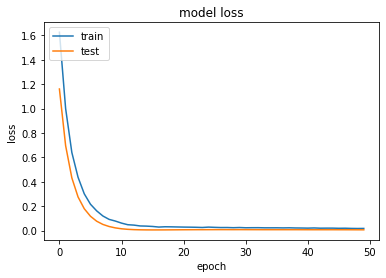

In [139]:
# summarize history for loss
plt.plot(model_a_1seq_sigmoid_history.history['loss'])
plt.plot(model_a_1seq_sigmoid_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model A (classification)

In [184]:
classification_df = df.dropna(subset=['text'])

In [185]:
classification_df['15mins_price_diff_positive'] = classification_df['15mins_price_diff_perc'].apply(lambda x: 1 if x >= 0 else 0)

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [186]:
classification_df

,id,text,favorites,retweets,date,tweet_datetime,date_part,time_part,hour,year,month,datetime_15mins_after,price_15mins_after,datetime_now,price_now,15mins_price_diff_abs,15mins_price_diff_perc,prev_30mins_prices,15mins_price_diff_positive
0,9.353400e+17,thank you rand,42793,9125,2017-11-28 02:50:00,2017-11-28 10:50:00,2017-11-28,10:50:00,10,2017,11,2017-11-28 11:05:00,261.150000,2017-11-28 10:50:00,261.100000,0.050000,0.000191,"[260.96, 261.03, 261.01, 261.015, 261.04, 261....",1
1,8.997980e+17,join me live from fort myer in arlington virginia,36009,4891,2017-08-22 01:00:00,2017-08-22 09:00:00,2017-08-22,09:00:00,9,2017,8,2017-08-22 09:15:00,243.630000,2017-08-22 09:00:00,243.670000,-0.040000,-0.000164,"[243.76, 243.79, 243.85, 243.86, 243.81, 243.7...",0
2,8.939700e+17,thank you nicole,43367,8275,2017-05-08 23:01:00,2017-05-09 07:01:00,2017-05-09,07:01:00,7,2017,5,2017-05-09 07:16:00,239.940000,2017-05-09 07:01:00,239.875000,0.065000,0.000271,"[239.73, 239.73, 239.73, 239.73, 239.73, 239.7...",1
3,8.819770e+17,thank you to shawn steel for the nice words on,50956,7465,2017-03-07 20:44:00,2017-03-08 04:44:00,2017-03-08,04:44:00,4,2017,3,2017-03-08 04:59:00,236.915000,2017-03-08 04:44:00,236.880000,0.035000,0.000148,"[236.84, 236.84, 236.84, 236.85333333333332, 2...",1
4,8.778460e+17,great night in iowa special people thank you,56446,8039,2017-06-22 11:11:00,2017-06-22 19:11:00,2017-06-22,19:11:00,19,2017,6,2017-06-22 19:26:00,242.893333,2017-06-22 19:11:00,242.880000,0.013333,0.000055,"[242.85, 242.85, 242.85, 242.85, 242.85, 242.8...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2607,9.990960e+17,if the person placed very early into my campai...,78529,20098,2018-05-23 01:13:00,2018-05-23 09:13:00,2018-05-23,09:13:00,9,2018,5,2018-05-23 09:28:00,271.110000,2018-05-23 09:13:00,271.040000,0.070000,0.000258,"[271.18, 271.16, 271.18, 271.15, 271.08, 271.0...",1
2608,9.874600e+17,so general michael flynns life can be totally ...,93569,25259,2018-04-20 10:34:00,2018-04-20 18:34:00,2018-04-20,18:34:00,18,2018,4,2018-04-20 18:49:00,266.890000,2018-04-20 18:34:00,266.820000,0.070000,0.000262,"[266.74625000000003, 266.7475, 266.74875, 266....",1
2609,9.870960e+17,my thoughts prayers and condolences are with t...,62645,16081,2018-04-19 22:30:00,2018-04-20 06:30:00,2018-04-20,06:30:00,6,2018,4,2018-04-20 06:45:00,268.910000,2018-04-20 06:30:00,268.620000,0.290000,0.001080,"[268.77, 268.74333333333334, 268.7166666666666...",1
2610,9.863570e+17,todays court decision means that congress must...,56749,12426,2018-04-17 21:34:00,2018-04-18 05:34:00,2018-04-18,05:34:00,5,2018,4,2018-04-18 05:49:00,270.710000,2018-04-18 05:34:00,270.600000,0.110000,0.000407,"[270.73, 270.7, 270.72749999999996, 270.755, 2...",1


In [187]:
# from keras.utils import to_categorical

classification_X = classification_df.loc[:, 'text']
classification_y = classification_df.loc[:, '15mins_price_diff_positive']
# classification_y = to_categorical(classification_y)

In [188]:
classification_X_train, classification_X_test, classification_y_train, classification_y_test = train_test_split(classification_X, classification_y, test_size=0.33, random_state=42)

In [189]:
classification_X_train_padded = word2vec_sentence_to_indices_padded(classification_X_train, model_a_longest_sentence_len, model_a_word2vec_model)
classification_X_test_padded = word2vec_sentence_to_indices_padded(classification_X_test, model_a_longest_sentence_len, model_a_word2vec_model)

In [190]:
def create_model_classification(pretrained_weights, longest_sentence_len):
    global embedding_layer_glove
    vocab_size, embedding_size = pretrained_weights.shape
    model = keras.Sequential()
    model.add(layers.Input(shape=longest_sentence_len, dtype='int32'))
#     model.add(embedding_layer_glove)
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_size, weights=[pretrained_weights], trainable=False))  
    model.add(layers.LSTM(4, return_sequences=True, name='LSTM1'))
    model.add(layers.Dropout(0.25,name='Dropout1'))
    model.add(layers.LSTM(4, return_sequences=False, name='LSTM2'))
    model.add(layers.Dropout(0.25,name='Dropout2'))
    model.add(layers.Dense(4,name='Dense',activation='sigmoid'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(2))
    return model

In [193]:
classification_model = create_model_classification(model_a_pretrained_weights, model_a_longest_sentence_len)
opt = keras.optimizers.Adam(learning_rate=0.001)
classification_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classification_model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 159, 100)          522200    
_________________________________________________________________
LSTM1 (LSTM)                 (None, 159, 4)            1680      
_________________________________________________________________
Dropout1 (Dropout)           (None, 159, 4)            0         
_________________________________________________________________
LSTM2 (LSTM)                 (None, 4)                 144       
_________________________________________________________________
Dropout2 (Dropout)           (None, 4)                 0         
_________________________________________________________________
Dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dropout_34 (Dropout)         (None, 4)               

In [194]:
from datetime import datetime

now = datetime.now()
dt_string = now.strftime("%d%m%Y %H%Mh")

checkpoint_filepath = f'./model_a_checkpoint/classification {dt_string}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose = 1,
    save_best_only=True) 

classification_history = classification_model.fit(classification_X_train_padded, classification_y_train, validation_split=0.2, epochs=50, callbacks=[model_checkpoint_callback])

Train on 1372 samples, validate on 344 samples
Epoch 1/50
1344/1372 [============================>.] - ETA: 0s - loss: 1.3375 - accuracy: 0.5394
Epoch 00001: val_loss improved from inf to 0.69218, saving model to ./model_a_checkpoint/classification 11112020 1926h.h5
1372/1372 [==============================] - 9s 7ms/sample - loss: 1.3389 - accuracy: 0.5372 - val_loss: 0.6922 - val_accuracy: 0.5843
Epoch 2/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.8404 - accuracy: 0.5208
Epoch 00002: val_loss improved from 0.69218 to 0.67904, saving model to ./model_a_checkpoint/classification 11112020 1926h.h5
1372/1372 [==============================] - 4s 3ms/sample - loss: 0.8369 - accuracy: 0.5226 - val_loss: 0.6790 - val_accuracy: 0.5843
Epoch 3/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.7906 - accuracy: 0.5260
Epoch 00003: val_loss did not improve from 0.67904
1372/1372 [==============================] - 4s 3ms/sample - loss: 0.7972 - accuracy: 0.52

Epoch 29/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5365
Epoch 00029: val_loss did not improve from 0.67904
1372/1372 [==============================] - 4s 3ms/sample - loss: 0.6940 - accuracy: 0.5357 - val_loss: 0.6855 - val_accuracy: 0.5843
Epoch 30/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.7058 - accuracy: 0.5335
Epoch 00030: val_loss did not improve from 0.67904
1372/1372 [==============================] - 4s 3ms/sample - loss: 0.7056 - accuracy: 0.5328 - val_loss: 0.6862 - val_accuracy: 0.5843
Epoch 31/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.6979 - accuracy: 0.5365
Epoch 00031: val_loss did not improve from 0.67904
1372/1372 [==============================] - 4s 3ms/sample - loss: 0.6983 - accuracy: 0.5386 - val_loss: 0.6864 - val_accuracy: 0.5843
Epoch 32/50
1344/1372 [============================>.] - ETA: 0s - loss: 0.7148 - accuracy: 0.52 - ETA: 0s - loss: 0.7140 - accuracy: 0.5231
Epoc

In [195]:
classification_loaded = create_model_classification(model_a_pretrained_weights, model_a_longest_sentence_len)
classification_loaded.load_weights(checkpoint_filepath)
classification_loaded.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classification_pred = classification_loaded.predict(model_a_X_test_padded)
classification_pred

array([[0.58781165, 0.80068463],
       [0.57438266, 0.78770894],
       [0.58350235, 0.7963762 ],
       ...,
       [0.59073013, 0.80347854],
       [0.578751  , 0.7915312 ],
       [0.59304094, 0.8057902 ]], dtype=float32)

In [197]:
[np.argmax(i) for i in classification_pred]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


<AxesSubplot:>

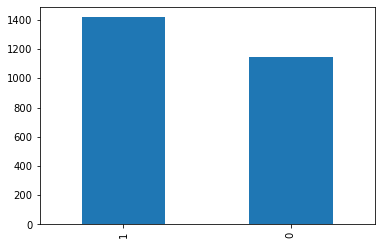

In [201]:
pd.value_counts(classification_y).plot(kind="bar")

# Model B (word vectors + price history)

In [ ]:
model_b_df = df.dropna(subset=['cleaned_text', 'prev_60mins_prices'])

model_b_X = model_b_df.loc[:, ['cleaned_text_2', 'prev_60mins_prices']]
model_b_y = model_b_df.loc[:, '60mins_price_diff_perc']

model_b_X_train, model_b_X_test, model_b_y_train, model_b_y_test = train_test_split(model_b_X, model_b_y, test_size=0.33, random_state=42)

model_b_X_train_text = model_b_X_train.iloc[:, 0]
model_b_X_train_price_history = model_b_X_train.iloc[:, 1].apply(lambda x: split(strip()))
model_b_X_test_text = model_b_X_test.iloc[:, 0]
model_b_X_test_price_history = model_b_X_test.iloc[:, 1]
                           
model_b_corpus_list = []

for i in model_b_X_train_text:
    model_b_corpus_list.append(i.split())
    
model_b_word2vec_model = Word2Vec(model_b_corpus_list, min_count=1, size=100)
model_b_pretrained_weights = model_b_word2vec_model.wv.vectors

model_b_num_words = [len(i) for i in model_b_corpus_list]
model_b_longest_sentence_len = max(model_b_num_words)

model_b_X_train_padded = sentence_to_indices_padded(model_b_X_train_text, model_b_longest_sentence_len)
model_b_X_test_padded = sentence_to_indices_padded(model_b_X_test_text, model_b_longest_sentence_len)

model_b_X_train_input = [model_b_X_train_padded, np.array(model_b_X_train_price_history)]
model_b_X_test_input = [model_b_X_test_padded, model_b_X_test_price_history]

In [ ]:
type(np.array(model_b_X_train_input[1]))

In [ ]:
def create_model_b(pretrained_weights, longest_sentence_len, price_history_shape):
    vocab_size, embedding_size = pretrained_weights.shape
    
    # word vectors model
    model1_input = layers.Input(shape=longest_sentence_len, dtype='int32', name='sentence_index_input')
    model1 = layers.Embedding(input_dim=vocab_size, output_dim=embedding_size, weights=[pretrained_weights], trainable=False)(model1_input)  
    model1 = layers.LSTM(4, return_sequences=True, name='model1_LSTM1')(model1)
    model1 = layers.Dropout(0.25,name='model1_dropout1')(model1)
    model1 = layers.LSTM(4, return_sequences=False, name='model1_LSTM2')(model1)
    model1 = layers.Dropout(0.25,name='model1_dropout2')(model1)
    
    # price history model
    model2_input = layers.Input(shape=price_history_shape, dtype='float32', name='price_history_input')
    model2 = layers.LSTM(4, return_sequences=True, name='model2_LSTM1')(model2_input)
    model2 = layers.Dropout(0.25,name='model2_dropout1')(model2)
    model2 = layers.LSTM(4, return_sequences=False, name='model2_LSTM2')(model2)
    model2 = layers.Dropout(0.25,name='model2_dropout2')(model2)
    
    model_concat = layers.concatenate([model1, model2])
    model_concat = layers.Dense(4,name='Dense',activation='relu')(model_concat)
    model_concat = layers.Dropout(0.1)(model_concat)
    model_concat = layers.Dense(1,activation='linear')(model_concat)
    
    model = keras.models.Model(inputs=[model1_input, model2_input], outputs = model_concat)
    
    return model

In [ ]:
model_b = create_model_b(model_b_pretrained_weights, model_b_longest_sentence_len, (30,1,))

In [ ]:
model_b.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
model_b.summary()

In [ ]:
from datetime import datetime

now = datetime.now()
dt_string = now.strftime("%d%m%Y %H%Mh")

checkpoint_filepath = f'./model_b_checkpoint/{dt_string}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose = 1,
    save_best_only=True) 

model_b.fit(model_b_X_train_input, model_b_y_train, validation_split=0.2, epochs=50, callbacks=[model_checkpoint_callback])

In [ ]:
model_b_X_train_input[1][0]